In [39]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix

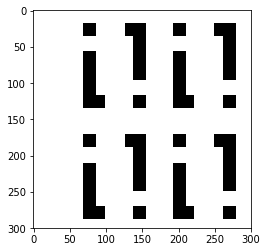

In [40]:
town_map = np.loadtxt('town_map.txt', dtype='uint8')
town_map_rotated = np.flip(town_map.T, axis=0)
plt.imshow(town_map_rotated, cmap='binary')
plt.show()

In [62]:
def conv_diff_solution(max_iter: int, 
                       eps: float, 
                       town_map: np.ndarray,
                       M: int = 300) -> np.ndarray:  
    lambda1 = 1.0
    k = 0.5
    h = 1 / M
    tau = 1 / (4 * k * M**2)

    A = lil_matrix((M**2, M**2))
    b = np.zeros(M**2)
    X = np.zeros(M**2)
    for i in range(M):
        X[i] = 1

    cross_params = {
        (0, 0)  : 1 - 4 * (tau * k) / h**2,
        (1, 0)  : tau * (k / h**2 - lambda1 / (2 * h)),
        (-1, 0) : tau * (k / h**2 + lambda1 / (2 * h)),
        (0, 1)  : tau * (k / h**2),
        (0, -1) : tau * (k / h**2)
    }
    
    out_of_bounds = lambda x, y: y < 0 or y > M - 1 or x > M - 1

    for x in range(M): 
        for y in range(M):
            if x == 0:
                A[y, y] = 1
                continue
                
            loc = x * M + y
            for (dx, dy), coef in cross_params.items():
                if (dx, dy) == (0, 0):
                    A[loc, loc] = coef
                    continue
                x_s, y_s = x + dx, y + dy

                if x_s == 0:
                    b[loc] += coef
                else:
                    town_x = int(x_s * town_map.shape[0] / M)
                    town_y = int(y_s * town_map.shape[0] / M)
                    if out_of_bounds(x_s, y_s) or town_map[town_x, town_y]:
                        A[loc, loc] += coef
                    else:
                        A[loc, x_s * M + y_s] = coef

    A = csr_matrix(A)

    for it in range(1, max_iter + 1):
        X_new = A * X + b
        error = np.max(np.abs(X_new - X))
        if it % 1000 == 0:
            print(f'\rIteration {it}/{max_iter}, Error = {error}     ', end='')
        if error < eps:
            print(f'\nTotal iterations = {it} | Final error = {error}')
            break
        X = X_new

    return np.flip(X.reshape((M, M)).T, axis=0)

Iteration 36000/100000, Error = 1.0073977293023617e-05     
Total iterations = 36218 | Final error = 9.999780229752453e-06


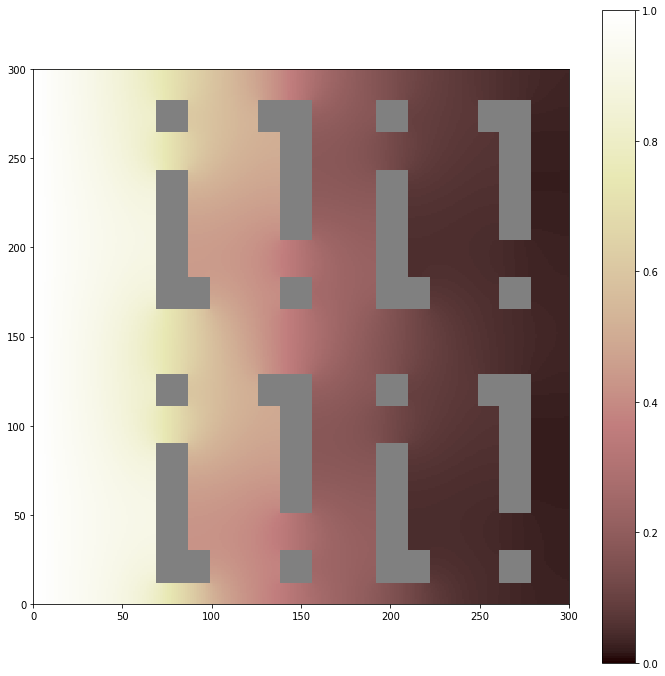

In [64]:
ans = conv_diff_solution(max_iter=100000, eps=1e-5, town_map=town_map, M=300)

scale = int(town_map.shape[0] / ans.shape[0])
for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        if town_map_rotated[i * scale, j * scale] == 1:
            ans[i, j] = -1
            
cmap = cm.get_cmap('pink')
cmap.set_under('gray')

plt.figure(figsize=(12, 12))
m_size = ans.shape[0]
im = plt.imshow(ans, cmap=cmap, extent=(0, m_size, 0, m_size),
                interpolation='nearest', vmin=0, vmax=1)
plt.clim(0, 1)
plt.colorbar(im);
plt.show()